# Eta Cru's Debri Disk Spectral Energy Distribution with mcfost

In the following script evaluates different values of disk radius, dust mass and dust grain in a theoretical spectral energy distribution model using mcfost software. 

This program writes, run and compare the results of the model with the actual observated data until it gets the best fit model. 


### Set the environment

Before runing the script, the following command should have been input in the linux terminal.
```
export MCFOST_UTILS=~/mcfost/utils
```

In [2]:
import subprocess
import astropy
from astropy.io import fits
from scipy import constants, stats
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as spi
from scipy.optimize import minimize, Bounds 
import time

### mcfost Negative log likelihood function



In [ ]:
def nll_mcfost(params,  lamob, fluxob, ferrob):
		
	amin = params[0]
	amax = params[1]
	d_mass = params[2]
	Rin = params[3]
	Rout = params[4]

	# 1. Create mcfost cfg file with parameters
	
	cfile = open("EtaCru.cfg", "w")
	cfile.write("3.0                      mcfost version\n")
	cfile.write("\n")
	cfile.write("#Number of photon packages\n")
	cfile.write("  1.28e5                  nbr_photons_eq_th  : T computation\n")
	cfile.write("  1.28e3	          nbr_photons_lambda : SED computation\n")
	cfile.write("  1.28e6                  nbr_photons_image  : images computation\n")
	cfile.write("\n")
	cfile.write("#Wavelength\n")
	cfile.write("  50  0.1 3000.0          n_lambda, lambda_min, lambda_max [mum] Do not change this line unless you know what you are doing\n")
	cfile.write("  T T T 		  compute temperature?, compute sed?, use default wavelength grid for output ?\n")
	cfile.write("  IMLup.lambda		  wavelength file (if previous parameter is F)\n")
	cfile.write("  F F			  separation of different contributions?, stokes parameters?\n")
	cfile.write("\n")
	cfile.write("#Grid geometry and size\n")
	cfile.write("  1			  1 = cylindrical, 2 = spherical (a Voronoi mesh is selected automatically with -phantom)\n")
	cfile.write(" 100 70 1 20              n_rad (log distribution), nz (or n_theta), n_az, n_rad_in\n")
	cfile.write("\n#Maps\n")
	cfile.write("  301 301 300.            grid (nx,ny), size [AU]\n")
	cfile.write("  0.    0.  1  F           RT: imin, imax, n_incl, centered ?\n")
	cfile.write("  0    0.   1             RT: az_min, az_max, n_az angles\n")
	cfile.write("  37.51			  distance (pc)\n")
	cfile.write("  -90.			  disk PA\n")
	cfile.write("\n#Scattering method\n")
	cfile.write("  0	                  0=auto, 1=grain prop, 2=cell prop\n")
	cfile.write("  1	                  1=exact phase function, 2=hg function with same g (2 implies the loss of polarizarion)\n")
	cfile.write("\n#Symmetries\n")
	cfile.write("  T	                  image symmetry\n")
	cfile.write("  T	                  central symmetry\n")
	cfile.write("  T	                  axial symmetry (important only if N_phi > 1)\n")
	cfile.write("\n#Disk physics\n")
	cfile.write("  0     0.50  1.0	  dust_settling (0=no settling, 1=parametric, 2=Dubrulle, 3=Fromang), exp_strat, a_strat (for parametric settling)\n")
	cfile.write("  F                       dust radial migration\n")
	cfile.write("  F		  	  sublimate dust\n")
	cfile.write("  F                       hydostatic equilibrium\n")
	cfile.write("  F  1e-5		  vimbb_bounds = Bounds(mbb_lower_bounds, mbb_upper_bounds)scous heating, alpha_viscosity\n")
	cfile.write("\n#Number of zones : 1 zone = 1 density structure + corresponding grain properties\n")
	cfile.write("  1                       needs to be 1 if you read a density file (phantom or fits file)\n")
	cfile.write("\n#Density structure\n")
	cfile.write("  4                       zone type : 1 = disk, 2 = tappered-edge disk, 3 = envelope, 4 = debris disk, 5 = wall\n")
	cfile.write(f"  {d_mass:.1g}    0.		  dust mass,  gas-to-dust mass ratio\n")
	cfile.write("  0.05   10.0   2           scale height, reference radius (AU), unused for envelope, vertical profile exponent (only for debris disk)\n")
	cfile.write(f"  {Rin}   0.2    {Rout}  {(Rout+Rin)/2}  Rin, edge, Rout, Rc (AU) Rc is only used for tappered-edge & debris disks (Rout set to 8*Rc if Rout==0)\n")
	cfile.write("  1.125                   flaring exponent, unused for envelope\n")
	cfile.write("  1  -1    	          surface density exponent (or -gamma for tappered-edge disk or volume density for envelope), usually < 0, -gamma_exp (or alpha_in & alpha_out for debris disk)\n")
	cfile.write("\n#Grain properties\n")
	cfile.write("  1  Number of species\n")
	cfile.write("  Mie  1 2  0.4  1.0  0.9 Grain type (Mie or DHS), N_components, mixing rule (1 = EMT or 2 = coating),  porosity, mass fraction, Vmax (for DHS)\n")
	cfile.write("  Draine_Si_sUV.dat  1.0  Optical indices file, volume fraction\n")
	cfile.write("  2	                  Heating method : 1 = RE + LTE, 2 = RE + NLTE, 3 = NRE\n")
	cfile.write(f"  {amin}   {amax} 3.5 100 	  amin, amax [mum], aexp, n_grains (log distribution)\n")
	cfile.write("\n#Molecular RT settings\n")
	cfile.write("  F F F 15.	          lpop, laccurate_pop, LTE, profile width [km/s]\n")
	cfile.write("  0.05 			  Turbulence velocity [km/s]\n")
	cfile.write("  1			  Number of molecules\n")
	cfile.write("  co.dat 6                molecular data filename, level max up to which NLTE populations are calculated\n")
	cfile.write("  10.0 20     	  	  vmax [km/s], number of velocity bins betwen 0 and vmax\n")
	cfile.write("  T 1.e-4 abundance.fits.gz   cst molecule abundance ?, abundance, abundance file\n")
	cfile.write("  T  2                       ray tracing ?,  number of lines in ray-tracing\n")
	cfile.write("  2 3	 		  transition numbers\n")
	cfile.write("\n#Star properties\n")
	cfile.write("  1 Number of stars\n")
	cfile.write("  7250.	1.87	1.75	0.0	0.0	0.0  T Temp, radius (solar radius),M (solar mass),x,y,z (AU), automatic spectrum?\n")
	cfile.write("  lte4000-3.5.NextGen.fits.gz\n")
	cfile.write("  0.0	2.2  fUV, slope_fUV\n")
	cfile.close()
	
	##2. Run mcfost with parameters of the .cfg
	#Remove previous data file
	subprocess.call("rm -rf data_*", shell=True)
	#Run mcfost Etacru.cfg
	subprocess.run("mcfost EtaCru.cfg", shell=True)
	#Uncompress SED files
	subprocess.call("gzip -d data_th/sed_rt.fits.gz", shell=True)
	subprocess.call("gzip -d data_th/sed_mc.fits.gz", shell=True)
	
	##3. Read mcfost output file
	
		# Ray tracing method SED
	SED_rt = fits.open("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits")
	flux_rt = fits.getdata("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits", ext=0)
	flux_rt = flux_rt[0,0,0] ##Flux units in Wemcee_mcfost/data_th/sed_rt.fits * m**-2
	lam_rt = fits.getdata("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits", ext=1)
	
	
	
	#4 interpolates SED predicted by mcfost to get predicted fluxes at our wavelengths 
		## Im just usind the RT-model
	interp = spi.interp1d(np.log10(lam_rt), np.log10(flux_rt), "cubic")
	flux_model = 10**(interp(np.log10(lamob))) #Wm**-2	
	
	
	## 5. likelihood of model
	
	logLik = -np.sum(stats.norm.logpdf(fluxob, loc=flux_model, scale=ferrob))
	
	return(logLik) 


In [3]:
#Observations data
lam_ob =np.array([24,70, 70, 100,160]) #microns
nu = constants.c/(lam_ob * 1e-6) #lam in meters
flux_ob=np.array([374.6, 702, 692, 704,440.3]) #Units in mJy
ferr_ob=np.array([3.8, 38, 52.6, 95.1, 146]) #Units in mJy
flux_ob *= 1e-29 * nu  #Units in W*m**-2
ferr_ob *= 1e-29 * nu #Units in W*m**-2	

#Minimize bounds
#amin, amax, d_mass
lower_bounds = np.array([1e-2, 5e2, 1e-10, 70, 101])
upper_bounds = np.array([1e1, 5e3, 1e-7, 100, 130 ])
bounds = Bounds(lower_bounds, upper_bounds)

guesses = np.array([1e-2, 1000, 9e-9, 105, 125])

args = (lam_ob, flux_ob, ferr_ob)

In [ ]:
start_time = time.time()

mcfost_result = minimize(nll_mcfost, guesses, args=args, method='Powell',bounds=bounds, options={'maxiter': 1000}) 
print(mcfost_result)

print("--- %s seconds ---" % (time.time() - start_time))

```
 direc: array([[ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.04899869,  4.43867692,  0.        , -1.30016047,  1.62904482]])
     fun: -139.73769509550877
 message: 'Optimization terminated successfully.'
    nfev: 418
     nit: 4
  status: 0
 success: True

Amin (microns) = 4.79953495e-01 
Amax (microns) = 5.79703066e+02 
Dust Mass (M) = 3.82584045e-08 
Rin (AU) = 7.71034287e+01 
Rout (AU) = 1.25111609e+02
```

### Read SED data files 

In [4]:
SED_rt = fits.open("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits")
flux_rt = fits.getdata("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits", ext=0)
flux_rt = flux_rt[0,0,0] ##Flux units in W * m**-2
lam_rt = fits.getdata("/home/iamcesarb/Delaware/Project/emcee_mcfost/data_th/sed_rt.fits", ext=1)

### Plot the SED

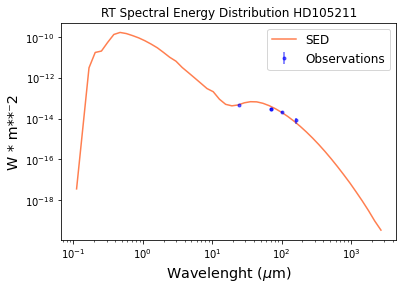

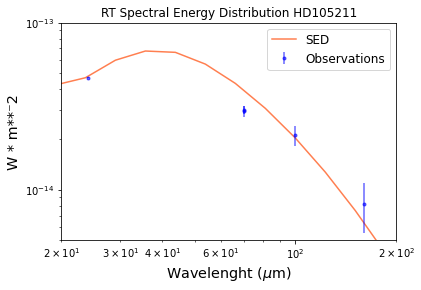

In [5]:
#SED Ray Tracing Method
plt.figure(1)
plt.plot(lam_rt, flux_rt, color='coral', label='SED')
plt.errorbar(lam_ob, flux_ob, yerr=ferr_ob, fmt='.', color='blue', alpha=0.6, label='Observations')
plt.xlabel('Wavelenght ($\mu$m)', fontsize='x-large')
plt.ylabel('W * m**⁻2', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plt.title("RT Spectral Energy Distribution HD105211")
plt.yscale("log")
plt.xscale("log")
plt.savefig("SED_rt.png", bbox_inches='tight')

#Zoomed SED
plt.figure(2)
plt.plot(lam_rt, flux_rt, color='coral', label='SED')
plt.errorbar(lam_ob, flux_ob, yerr=ferr_ob, fmt='.', color='blue', alpha=0.6, label='Observations')
plt.xlabel('Wavelenght ($\mu$m)', fontsize='x-large')
plt.ylabel('W * m**⁻2', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plt.title("RT Spectral Energy Distribution HD105211")
plt.yscale("log")
plt.xscale("log")
plt.xlim([2e1,2e2 ])
plt.ylim([5e-15,1e-13])
plt.savefig("SED2_rt.png", bbox_inches='tight')
